<a href="https://colab.research.google.com/github/dsirt/Data-Engineering-Bootcamp/blob/main/LineerRegression_Albaraka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install delta-spark==2.4.0

In [9]:
from pyspark.sql import SparkSession

# Add Delta Lake package dependency
spark = SparkSession \
    .builder \
    .appName('Linear Regression with PySpark') \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:2.4.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .getOrCreate()

# Read the CSV file using the correct format
df = spark.read.format('csv').\
    options(header = 'true', inferschema = 'true').\
    load("/content/advertising.csv")

df.printSchema()
df.show(5)

root
 |-- TV: double (nullable = true)
 |-- Radio: double (nullable = true)
 |-- Newspaper: double (nullable = true)
 |-- Sales: double (nullable = true)

+-----+-----+---------+-----+
|   TV|Radio|Newspaper|Sales|
+-----+-----+---------+-----+
|230.1| 37.8|     69.2| 22.1|
| 44.5| 39.3|     45.1| 10.4|
| 17.2| 45.9|     69.3| 12.0|
|151.5| 41.3|     58.5| 16.5|
|180.8| 10.8|     58.4| 17.9|
+-----+-----+---------+-----+
only showing top 5 rows



In [12]:
df.describe().show()

+-------+-----------------+------------------+------------------+------------------+
|summary|               TV|             Radio|         Newspaper|             Sales|
+-------+-----------------+------------------+------------------+------------------+
|  count|              200|               200|               200|               200|
|   mean|         147.0425|23.264000000000024|30.553999999999995|15.130500000000005|
| stddev|85.85423631490805|14.846809176168728| 21.77862083852283| 5.283892252561875|
|    min|              0.7|               0.0|               0.3|               1.6|
|    max|            296.4|              49.6|             114.0|              27.0|
+-------+-----------------+------------------+------------------+------------------+



In [13]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

def transData(data):
    return data.rdd.map(lambda r : [Vectors.dense(r[:-1]), r[-1]]).toDF(['features', 'label'])

transformed = transData(df)
transformed.show(5)

+-----------------+-----+
|         features|label|
+-----------------+-----+
|[230.1,37.8,69.2]| 22.1|
| [44.5,39.3,45.1]| 10.4|
| [17.2,45.9,69.3]| 12.0|
|[151.5,41.3,58.5]| 16.5|
|[180.8,10.8,58.4]| 17.9|
+-----------------+-----+
only showing top 5 rows



In [14]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

featureIndexer = VectorIndexer(inputCol = "features", outputCol = "indexedFeatures", maxCategories = 4).fit(transformed)

data = featureIndexer.transform(transformed)

data.show(5)

+-----------------+-----+-----------------+
|         features|label|  indexedFeatures|
+-----------------+-----+-----------------+
|[230.1,37.8,69.2]| 22.1|[230.1,37.8,69.2]|
| [44.5,39.3,45.1]| 10.4| [44.5,39.3,45.1]|
| [17.2,45.9,69.3]| 12.0| [17.2,45.9,69.3]|
|[151.5,41.3,58.5]| 16.5|[151.5,41.3,58.5]|
|[180.8,10.8,58.4]| 17.9|[180.8,10.8,58.4]|
+-----------------+-----+-----------------+
only showing top 5 rows



In [15]:
(trainingData, testData) = data.randomSplit([0.6, 0.4])
trainingData.show(5)
testData.show(5)

+---------------+-----+---------------+
|       features|label|indexedFeatures|
+---------------+-----+---------------+
| [4.1,11.6,5.7]|  3.2| [4.1,11.6,5.7]|
|[7.8,38.9,50.6]|  6.6|[7.8,38.9,50.6]|
| [8.4,27.2,2.1]|  5.7| [8.4,27.2,2.1]|
|  [8.6,2.1,1.0]|  4.8|  [8.6,2.1,1.0]|
|[8.7,48.9,75.0]|  7.2|[8.7,48.9,75.0]|
+---------------+-----+---------------+
only showing top 5 rows

+----------------+-----+----------------+
|        features|label| indexedFeatures|
+----------------+-----+----------------+
|  [0.7,39.6,8.7]|  1.6|  [0.7,39.6,8.7]|
|  [5.4,29.9,9.4]|  5.3|  [5.4,29.9,9.4]|
| [7.3,28.1,41.4]|  5.5| [7.3,28.1,41.4]|
| [17.2,4.1,31.6]|  5.9| [17.2,4.1,31.6]|
|[17.2,45.9,69.3]| 12.0|[17.2,45.9,69.3]|
+----------------+-----+----------------+
only showing top 5 rows



In [16]:
lr = LinearRegression()

pipeline = Pipeline(stages = [featureIndexer, lr])

model = pipeline.fit(trainingData)

In [17]:
predictions = model.transform(testData)

predictions.select("features", "label", "prediction").show(5)

+----------------+-----+-----------------+
|        features|label|       prediction|
+----------------+-----+-----------------+
|  [0.7,39.6,8.7]|  1.6|9.276410999724995|
|  [5.4,29.9,9.4]|  5.3| 8.47681994558304|
| [7.3,28.1,41.4]|  5.5|8.216939969724812|
| [17.2,4.1,31.6]|  5.9|6.207165606980883|
|[17.2,45.9,69.3]| 12.0| 10.5118812941027|
+----------------+-----+-----------------+
only showing top 5 rows



In [18]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol = 'label', predictionCol = 'prediction', metricName = 'rmse')

rmse = evaluator.evaluate(predictions)
print('Root Mean Square Error (RMSE) on test data = %g' % rmse)

Root Mean Square Error (RMSE) on test data = 1.56406


In [19]:
#r2-score hesabı

y_true = predictions.select('label').toPandas()
y_pred = predictions.select('prediction').toPandas()

import sklearn.metrics

r2_score = sklearn.metrics.r2_score(y_true, y_pred)
print('r2_score: {0}'.format(r2_score))

r2_score: 0.9155766734674027


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [22]:
# 'label' ve 'prediction' sütunlarını seçin ve pandas DataFrame'ine dönüştürün
pdf = predictions.select("label", "prediction").toPandas()

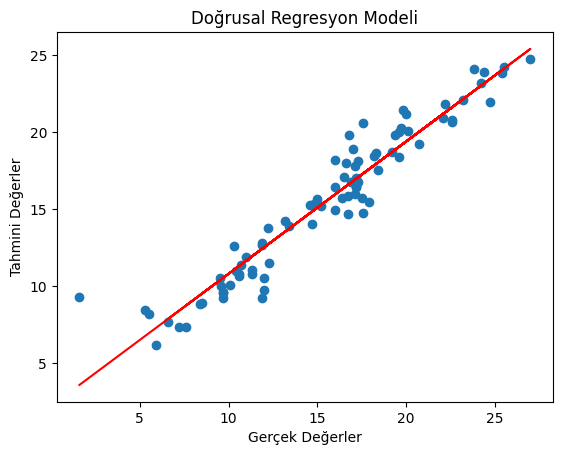

In [23]:
# Gerçek değerleri (etiketleri) x ekseninde ve tahmini değerleri y ekseninde çizdirin
plt.scatter(pdf["label"], pdf["prediction"])

# Regresyon çizgisini hesaplayın ve çizdirin
# np.polyfit() fonksiyonu regresyon çizgisini hesaplamak için kullanılır
# np.poly1d() fonksiyonu ise bir polinom fonksiyonu oluşturmak için kullanılır
m, b = np.polyfit(pdf["label"], pdf["prediction"], 1)
plt.plot(pdf["label"], m * pdf["label"] + b, color="red")

# Grafiğe başlık ve eksen etiketleri ekleyin
plt.title("Doğrusal Regresyon Modeli")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmini Değerler")

# Grafiği görüntüleyin
plt.show()